In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Configuración y rutas
data_dir = '/content/drive/MyDrive/TFG/dataset_clasificacion'
save_model_path = '/content/drive/MyDrive/TFG/modelos_clasificacion/vgg19_adenoma_vs_serrado.pth'
os.makedirs(os.path.dirname(save_model_path), exist_ok=True)

# Transformaciones
img_size = 224

transform = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}



Mounted at /content/drive


In [ ]:
# Dataset y DataLoader
batch_size = 32

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'))
    for x in ['train', 'val', 'test']
}

class_names = image_datasets['train'].classes
print(f"Clases detectadas: {class_names}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




Clases detectadas: ['Adenoma', 'Serrado']


In [ ]:
# Modelo VGG19
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Congelar capas

# Reemplazar clasificador final
model.classifier[6] = nn.Linear(4096, 2)
model = model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.0005)
num_epochs = 100
best_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), save_model_path)
                print(f"✅ Modelo mejorado guardado con acc={best_acc:.4f}")

        print(f"{phase.capitalize()} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


🔁 Epoch 1/100
Train - Loss: 0.6641 Acc: 0.5968
✅ Modelo mejorado guardado con acc=0.6500
Val - Loss: 0.5704 Acc: 0.6500

🔁 Epoch 2/100
Train - Loss: 0.5728 Acc: 0.7090
✅ Modelo mejorado guardado con acc=0.7417
Val - Loss: 0.5589 Acc: 0.7417

🔁 Epoch 3/100
Train - Loss: 0.5292 Acc: 0.7292
Val - Loss: 0.5170 Acc: 0.7333

🔁 Epoch 4/100
Train - Loss: 0.5060 Acc: 0.7500
✅ Modelo mejorado guardado con acc=0.7667
Val - Loss: 0.5042 Acc: 0.7667

🔁 Epoch 5/100
Train - Loss: 0.5057 Acc: 0.7328
Val - Loss: 0.5069 Acc: 0.7583

🔁 Epoch 6/100
Train - Loss: 0.4672 Acc: 0.7773
✅ Modelo mejorado guardado con acc=0.8000
Val - Loss: 0.4862 Acc: 0.8000

🔁 Epoch 7/100
Train - Loss: 0.4683 Acc: 0.7631
Val - Loss: 0.4869 Acc: 0.7750

🔁 Epoch 8/100
Train - Loss: 0.4646 Acc: 0.7726
Val - Loss: 0.5098 Acc: 0.7500

🔁 Epoch 9/100
Train - Loss: 0.4507 Acc: 0.7732
Val - Loss: 0.4718 Acc: 0.8000

🔁 Epoch 10/100
Train - Loss: 0.4474 Acc: 0.7951
Val - Loss: 0.4791 Acc: 0.7750

🔁 Epoch 11/100
Train - Loss: 0.4529 Acc:

In [ ]:

# Evaluación en test
print("\n🔍 Evaluando en conjunto de test...")
model.load_state_dict(torch.load(save_model_path))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Reporte
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



🔍 Evaluando en conjunto de test...

📊 Classification Report:
              precision    recall  f1-score   support

     Adenoma       0.83      0.78      0.81        32
     Serrado       0.78      0.83      0.81        30

    accuracy                           0.81        62
   macro avg       0.81      0.81      0.81        62
weighted avg       0.81      0.81      0.81        62



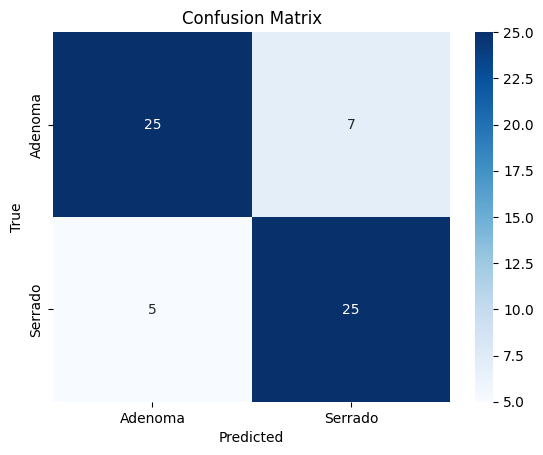

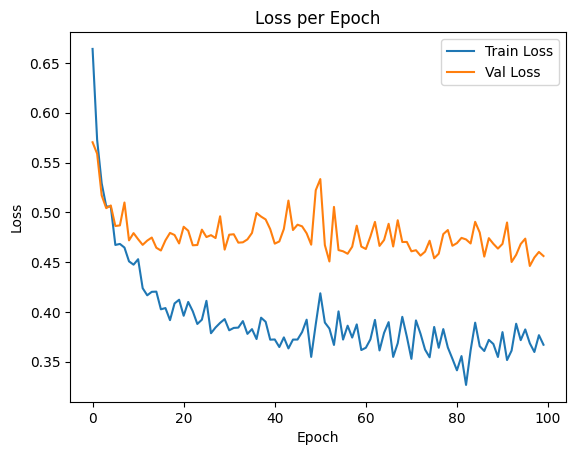

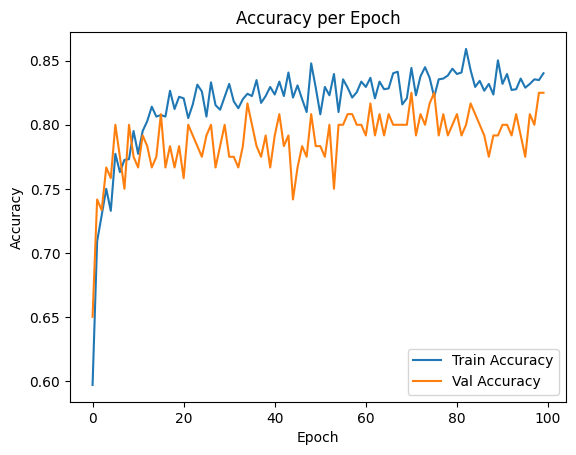

In [ ]:

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Visualización de métricas
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
